In [2]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [5]:
num_notes = 128
num_time_shifts = 100
message_dim = 2*num_notes + num_time_shifts
program_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
max_channels = 14

In [ ]:
print(message_dim)

# EnsembleTransformer definition

In [56]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].unsqueeze(1).expand(-1, x.shape[1], -1)
        return self.dropout(x)

# EnsembleTransformer: takes a history of MIDI messages 
# for instruments in an ensemble and generates a distribution for the next message,
# as well as the instrument (the channel) who should issue the message
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    def __init__(self, message_dim, embed_dim, heads, attention_layers, ff_size):
        super(EnsembleTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Indicates channel numbers, as well as
        # the position of messages in time
        self.position_encoding = PositionalEncoding(embed_dim)
        
        # The decoder computes attention over the message history, using the channel
        # encodings as memory
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        decoder_layer = torch.nn.TransformerDecoderLayer(2*embed_dim, heads, ff_size)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, attention_layers)

        # The decoding is passed through a linear layer to get the logits for the next message        
        self.message_logits = torch.nn.Linear(2*embed_dim, message_dim)
        
        # The decoding becomes a query for attention across the channels, which is used to
        # predict the next channel
        self.channel_attention = torch.nn.MultiheadAttention(2*embed_dim, heads)
    
    # forward: generates a probability distribution for the next MIDI message
    # and the channel that issues the message, given a message history for the ensemble
    # ARGUMENTS
    # history: an LxBx2 tensor, where L is the length of the longest message history in
    # the batch, and B is the batch size. The first index along dimension 2 stores the
    # message number. The second stores the channel number. This should be END-PADDED
    # along dimension 0. All time shifts should be associated with channel -1.
    # mask: an LxB tensor, containing True in any locations where history contains
    # padding and False elsewhere
    # nchan: a length B tensor telling us how many channels are in each instance in the batch
    # RETURN: two tensors. The first is LxBxD, representing the distribution for the next message at each time
    # step (need to take the softmax to get actual probabilities). The second is LxBxC, representing the
    # distribution for the next channel at each time step
    def forward(self, history, mask, nchan):
        L = history.shape[0] # longest length
        B = history.shape[1] # batch size
        assert(mask.shape == (L, B))
        
        max_chan = torch.max(nchan)
        channels = torch.zeros((max_chan, B, 2*self.embed_dim))
        channels[:, :, :embed_dim] = self.position_encoding(torch.zeros((max_chan, B, self.embed_dim)))
        
        # Contains False where a channel exists and True otherwise
        channel_mask = torch.ones((max_chan, B), dtype=torch.bool)
        
        for b in range(B):
            channel_mask[:nchan[b], b] = False
        
        # Which messages are time shifts?
        time_shift_mask = history[:, :, 1] < 0
        
        # LxBxD
        channel_sel = history[:, :, 1].unsqueeze(2).expand(-1, -1, self.embed_dim).clone()
        channel_sel[time_shift_mask] = 0
        
        channel_tags = torch.gather(channels, 0, channel_sel)
        channel_tags[time_shift_mask] = 0
        
        # LxBxD
        decoder_inputs = torch.cat((self.position_encoding(self.embedding(history[:, :, 0])), \
                                    channel_tags), dim=2)
        
        tgt_mask = torch.triu(torch.ones((L, L), dtype=torch.bool))
        tgt_mask.fill_diagonal_(False)
        tgt_key_padding_mask = mask.transpose(0, 1)
        
        decoding = self.decoder(decoder_inputs, channels, \
                                tgt_mask=tgt_mask, \
                                tgt_key_padding_mask=tgt_key_padding_mask,
                                memory_key_padding_mask=channel_mask.transpose(0, 1))
        
        # LxBxD
        message_dist = self.message_logits(decoding)
        
        # channel_dist (BxLxC) contains the attention weights for each channel.
        # We have L queries (the elements of decoding). Our keys and values
        # are the instrument embeddings
        att_out, channel_probs = self.channel_attention(decoding, \
                                                        channels, channels,
                                                        key_padding_mask=channel_mask.transpose(0, 1))
        
        return message_dist, channel_probs.transpose(0, 1)

# Tests for EnsembleTransformer
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single song

In [57]:
embed_dim = 256
heads = 4
attention_layers = 6
ff_size = 512

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, heads, attention_layers, ff_size)    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [35]:
model.load_state_dict(torch.load('unified_transformer.pth'))

<All keys matched successfully>

In [58]:
recording = np.load('train_unified/recording0.npy', allow_pickle=True)
instruments_np = np.load('train_unified/instruments0.npy', allow_pickle=True)

nsamples = 500

history = torch.tensor(recording[:nsamples], dtype=torch.long).view(-1, 1, 2)
mask = torch.zeros((history.shape[0], history.shape[1]), dtype=torch.bool)
nchan = torch.tensor([instruments_np.shape[0]])

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
message_loss = torch.nn.CrossEntropyLoss()
channel_loss = torch.nn.NLLLoss(ignore_index=-1)
epochs = 500
train_losses = np.zeros(epochs)

target_messages = history[1:, :, 0].flatten()
target_channels = history[1:, :, 1].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    message_logits, channel_probs = model(history[:-1], mask[:-1], nchan)
    channel_log_probs = torch.log(channel_probs + 1e-8)
    
    loss = message_loss(message_logits.view(-1, message_dim), target_messages) + \
           channel_loss(channel_log_probs.view(-1, nchan), target_channels)
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

Starting epoch 0
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 8.239785
Starting epoch 1
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 5.928912
Starting epoch 2
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 6.054917
Starting epoch 3
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 5.482859
Starting epoch 4
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 5.128570
Starting epoch 5
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 4.949430
Starting epoch 6
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 4.846774
Starting epoch 7
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 4.692304
Starting epoch 8
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])
Loss: 4.658298
Starting epoch 9
torch.Size([8, 1, 512])
torch.Size([499, 1, 256])


KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), 'unified_transformer.pth')

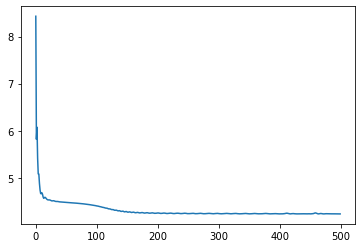

In [19]:
plt.plot(train_losses)

In [40]:
# Sample from model
gen_history = history[0].unsqueeze(0)
gen_mask = torch.zeros((1, 1), dtype=torch.bool)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

# Move forward in time
wrong_cnt = 0
for t in range(1, history.shape[0]):
    message_logits, channel_dist = model(history[:t], mask[:t], nchan)
    
    #message = torch.multinomial(torch.softmax(message_logits[-1].flatten(), dim=0), 1)
    #channel = torch.multinomial(channel_dist[-1].flatten(), 1)
    
    message = torch.argmax(message_logits[-1].flatten())
    channel = torch.argmax(channel_dist[-1].flatten())
    
    append = torch.tensor([message, channel]).view(1, 1, 2)
    
    gen_history = torch.cat((gen_history, append), dim=0)
    
    if gen_history[-1, 0, 0] != history[t, 0, 0]:
        print('Wrong message at time %d!' %(t))
        wrong_cnt += 1
        
    '''
    if gen_history[-1, 0, 1] != history[t, 0, 1]:
        print('Wrong channel at time %d!' %(t))
        wrong_cnt += 1
    '''
    
    gen_mask = torch.cat((gen_mask, torch.zeros((1, 1), dtype=torch.bool)), dim=0)

print(wrong_cnt)

tensor(267)
tensor(267)
Wrong message at time 2!
tensor(267)
Wrong message at time 3!
tensor(267)
tensor(267)
Wrong message at time 5!
tensor(267)
Wrong message at time 6!
tensor(267)
tensor(267)
Wrong message at time 8!
tensor(267)
Wrong message at time 9!
tensor(267)
tensor(267)
Wrong message at time 11!
tensor(267)
Wrong message at time 12!
tensor(267)
tensor(267)
Wrong message at time 14!
tensor(267)
Wrong message at time 15!
tensor(267)
tensor(267)
Wrong message at time 17!
tensor(267)
Wrong message at time 18!
tensor(267)
tensor(267)
Wrong message at time 20!
tensor(267)
Wrong message at time 21!
tensor(267)
tensor(267)
Wrong message at time 23!
tensor(267)
Wrong message at time 24!
tensor(267)
tensor(267)
Wrong message at time 26!
tensor(267)
Wrong message at time 27!
tensor(267)
tensor(267)
Wrong message at time 29!
tensor(267)
Wrong message at time 30!
tensor(267)
tensor(267)
Wrong message at time 32!
tensor(267)
Wrong message at time 33!
tensor(267)
tensor(267)
Wrong message 

In [25]:
print(history[:, :, 0])

tensor([[ 51],
        [267],
        [179],
        [ 55],
        [267],
        [183],
        [ 51],
        [267],
        [179],
        [ 55],
        [267],
        [183],
        [ 63],
        [267],
        [191],
        [ 55],
        [267],
        [183],
        [ 51],
        [267],
        [179],
        [ 55],
        [267],
        [183],
        [ 51],
        [267],
        [179],
        [ 55],
        [267],
        [183],
        [ 63],
        [267],
        [191],
        [ 55],
        [267],
        [183],
        [ 60],
        [ 48],
        [ 55],
        [ 36],
        [ 43],
        [ 51],
        [267],
        [188],
        [176],
        [183],
        [164],
        [171],
        [179],
        [ 55],
        [267],
        [183],
        [ 51],
        [267],
        [179],
        [ 55],
        [ 55],
        [ 43],
        [ 55],
        [267],
        [183],
        [183],
        [171],
        [183],
        [ 63],
        [267],
        [1

In [44]:
np.save('test_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('test_instruments.npy', [instrument_numbers[i] for i in instruments[:-1, 0]])

# Custom dataset class

In [7]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a tensor of message chunks and associated instruments.
    # Assumes that the directory contains recording0.npy to recordingM.npy
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    # chunk_size: we'll chunk the data into chunks of this size (or less)
    # max_channels: what's the largest number of instruments in any file?
    def __init__(self, root_dir, chunk_size, max_channels, transform=None):
        files = os.listdir(root_dir)
        recording_files = []
        instrument_files = []
        for file in files:
            if 'recording' in file:
                recording_files.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(recording_files) == len(instrument_files))
        recording_files.sort()
        instrument_files.sort()
        
        self.chunks = []
        self.masks = []
        self.instruments = []
        self.inst_masks = []
        
        ch = 0
        for f in range(len(recording_files)):
            recording = np.load(recording_files[f], allow_pickle=True)
            inst = [instrument_numbers.index(i) for i in np.load(instrument_files[f], allow_pickle=True)]
            
            nchunks = int(np.ceil(recording.shape[0]/chunk_size))
            self.chunks += [torch.zeros((chunk_size, 2), dtype=torch.long) for c in range(nchunks)]
            self.masks += [torch.ones(chunk_size, dtype=torch.bool) for c in range(nchunks)]
            self.instruments += [torch.zeros(max_channels, dtype=torch.long) for c in range(nchunks)]
            self.inst_masks += [torch.ones(max_channels, dtype=torch.long) for c in range(nchunks)]
            for chunk_start in range(0, recording.shape[0], chunk_size):
                chunk_end = min(chunk_start + chunk_size, recording.shape[0])
                size = chunk_end - chunk_start
                self.chunks[ch][:size] = torch.tensor(recording[chunk_start:chunk_end], dtype=torch.long)
                self.masks[ch][:size] = False
                self.instruments[ch][:len(inst)] = torch.tensor(inst, dtype=torch.long)
                self.inst_masks[ch][:len(inst)] = False
                ch += 1
            
        self.transform = transform

    # __len__
    # RETURN: the number of recording chunks in the dataset
    def __len__(self):
        return len(self.chunks)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which chunk(s) to get
    # RETURN: instance, a dictionary with keys 'history' and 'instruments'
    # instance['history'] is an Lx2 tensor containing messages and associated channels
    # instance['instruments'] a length N tensor of instrument numbers
    # instance['mask'] a length L tensor containing False where messages exist and True otherwise
    # instance['inst_mask'] a length N tensor containing False where instruments exist and True otherwise
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        instance = {'history': self.chunks[idx], \
                    'instruments': self.instruments[idx],
                    'mask': self.masks[idx],
                    'inst_mask': self.inst_masks[idx]}
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance
    
def collate_fn(batch):
    chunk_size = batch[0]['history'].shape[0]
    max_channels = batch[0]['instruments'].shape[0]
    sample = {'history': torch.zeros((chunk_size, len(batch), 2), dtype=torch.long), \
              'instruments': torch.ones((max_channels, len(batch)), dtype=torch.long), \
              'mask': torch.ones((chunk_size, len(batch)), dtype=torch.bool),
              'inst_mask': torch.ones((max_channels, len(batch)), dtype=torch.bool)}
    
    for b, instance in enumerate(batch):
        sample['history'][:, b] = instance['history']
        sample['instruments'][:, b] = instance['instruments']
        sample['mask'][:, b] = instance['mask']
        sample['inst_mask'][:, b] = instance['inst_mask']
    return sample

# Train the model

In [8]:
# compute_loss: computes the loss for the model over the batch
# ARGUMENTS
# model: EnsembleTransformer model
# message_loss_fn: torch.nn.CrossEntropyLoss object
# channel_loss_fn: torch.nn.NLLLoss object
# batch: see collate_fn definition
# RETURN: a scalar loss tensor
def compute_loss(model, message_loss_fn, channel_loss_fn, batch):  
    max_seq_length = batch['history'].shape[0]

    message_logits, channel_dist = model(batch['history'][:-1], batch['mask'][:-1], batch['instruments'], batch['inst_mask'])
    log_channel_dist = torch.log(channel_dist + 1e-10)

    target_mask = torch.logical_not(batch['mask'][1:])

    message_loss = message_loss_fn(message_logits[target_mask], batch['history'][1:, :, 0][target_mask])
    channel_loss = channel_loss_fn(log_channel_dist[target_mask], batch['history'][1:, :, 1][target_mask])

    return message_loss + channel_loss

In [9]:
embed_dim = 512
heads = 4
attention_layers = 6
ff_size = 512

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [10]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 10
learning_rate = 0.001
chunk_size = 500

train_dataset = MIDIDataset('train_unified', chunk_size, max_channels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = MIDIDataset('test_unified', chunk_size, max_channels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

message_loss_fn = torch.nn.CrossEntropyLoss()
channel_loss_fn = torch.nn.NLLLoss(ignore_index=-1)
epochs = 20
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    model.train()
    for b, batch in enumerate(train_dataloader):
        print('Starting iteration %d' %(b))
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    torch.save(model.state_dict(), 'unified_transformer_models/epoch' + str(epoch) + '.pth')

    print('Computing test loss')
    model.eval()
    for batch in test_dataloader:
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        test_losses[epoch] += loss.data
        
    print('Computing train loss')
    for batch in train_dataloader:
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        train_losses[epoch] += loss.data
    
    train_losses[epoch] /= len(train_dataloader)
    test_losses[epoch] /= len(test_dataloader)
    print('Train Loss: %f, Test Loss: %f' %(train_losses[epoch], test_losses[epoch]))

In [ ]:
plt.plot(train_losses)

# Sample from the model

In [115]:
model.eval() # Disable dropout to make results repeatable

time_steps = 500 # How many time steps do we sample?

# Start with a time shift
gen_history = torch.zeros((1, 1, 2), dtype=torch.long)
gen_history[0, 0, 0] = 387
gen_history[0, 0, 1] = -1

# Violin
instruments = torch.zeros((1, 1), dtype=torch.long)
instruments[0, 0] = 0
inst_mask = torch.zeros((1, 1), dtype=torch.bool)

gen_mask = torch.zeros((1, 1), dtype=torch.bool)

# Move forward in time
for t in range(0, time_steps):
    message_logits, channel_logits = model(gen_history, gen_mask, instruments)
    
    message = torch.multinomial(torch.softmax(message_logits[-1].flatten(), dim=0), 1)
    channel = torch.multinomial(channel_logits[-1].flatten(), 1)
    
    append = torch.tensor([message, channel]).view(1, 1, 2)
    
    gen_history = torch.cat((gen_history, append), dim=0)
    
    gen_mask = torch.cat((gen_mask, torch.zeros((1, 1), dtype=torch.bool)), dim=0)

print(wrong_cnt)

In [116]:
np.save('gen_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('gen_instruments.npy', [instrument_numbers[i] for i in instruments[:, 0]])